In [536]:
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn import tree
import pandas as pd
import pickle
import csv
from csv import writer
import tensorflow.compat.v1 as tf 
from scipy.stats import norm
%load_ext tensorboard
import seaborn as sns

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [410]:
def agregarComoFila(archivo, elementos):
    with open(archivo, 'a+', newline='') as write_obj:
        csv_writer = writer(write_obj)
        csv_writer.writerow(elementos)
datadf = pd.read_csv('data_titanic_proyecto.csv',index_col = 'PassengerId')

In [411]:
# Vamos a ver un resumen
datadf.head()

,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
PassengerId,,,,,,,,,,,
1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Lower,M,N
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Upper,F,Y
3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Lower,F,Y
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Upper,F,Y
5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Lower,M,N


# Exploracion y Feature Engineering

In [231]:
# En la primera linea vemos que hay valores NAN
# por lo cual vamos a buscar que columnas tienen valores vacios o null
datadf.isnull().sum()

Name                    0
Age                   177
SibSp                   0
Parch                   0
Ticket                  0
Fare                    0
Cabin                 687
Embarked                2
passenger_class         0
passenger_sex           0
passenger_survived      0
dtype: int64

In [232]:
# vamos a remplazar los valores
datadf['Embarked'] = datadf['Embarked'].fillna('C')
datadf['Age']      = datadf['Age'].fillna(datadf['Age'].median())
datadf['Fare']     = datadf['Fare'].fillna(datadf['Fare'].median())
datadf['Cabin']    = datadf['Cabin'].fillna('Z')
datadf['Cabin']    = datadf['Cabin'].apply(lambda x: str(x)[0])

In [233]:
# Ahora vamos a revisar que no hayan mas nulos
datadf.isnull().sum()

Name                  0
Age                   0
SibSp                 0
Parch                 0
Ticket                0
Fare                  0
Cabin                 0
Embarked              0
passenger_class       0
passenger_sex         0
passenger_survived    0
dtype: int64

In [234]:
# Un poco de analisis exploratorio
datadf['passenger_survived'].head()

PassengerId
1    N
2    Y
3    Y
4    Y
5    N
Name: passenger_survived, dtype: object

In [235]:
datadf['passenger_survived'].describe()

count     891
unique      2
top         N
freq      549
Name: passenger_survived, dtype: object

In [236]:
# Vamos a pasarlo a 1 y 0

datadf['passenger_survived'] = datadf['passenger_survived'].map({'Y':1,'N':0})
datadf['passenger_survived'].describe()

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: passenger_survived, dtype: float64

In [237]:
datadf['Cabin'].unique()

array(['Z', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

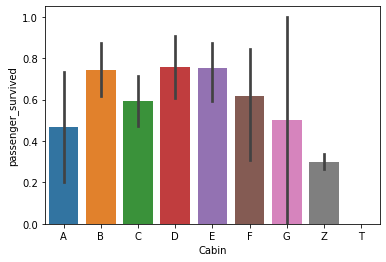

In [238]:
# Vamos a revisar la columna Cabin con passenger survived 
sns.barplot(x= 'Cabin', y = 'passenger_survived', data = datadf ,order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'Z', 'T'])

In [239]:
# Vemos que hay tres rangos de probabilidad por lo cual vamos a unificar en grupos de alto medio bajo
# y X para los que no tengan
datadf['Cabin'] = datadf['Cabin'].replace(['B', 'D', 'E'], 'H')   #Alto
datadf['Cabin'] = datadf['Cabin'].replace(['F', 'C'], 'M')        #Medio
datadf['Cabin'] = datadf['Cabin'].replace(['T', 'G', 'A',], 'L')  #Bajo
datadf['Cabin'] = datadf['Cabin'].replace(['Z'],'X')

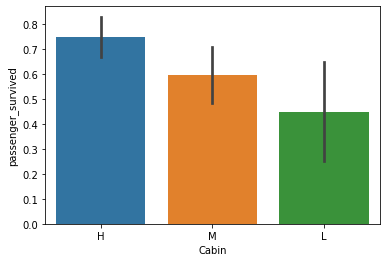

In [240]:
# Esto es mas manejable
sns.barplot(x= 'Cabin', y = 'passenger_survived', data = datadf ,order = ['H', 'M', 'L'])

In [241]:
# Vamos a unificar la columna SibSp = Siblings and Spor y Parent Children en la columna Familia y viajasolo
datadf['Familia'] = datadf['SibSp'] + datadf['Parch'] + 1
datadf['Solo']  = datadf['Familia'].apply(lambda x: 1 if x == 1 else 0)
datadf.drop(['SibSp','Parch'],axis = 1, inplace = True)

In [242]:
# Tambien vamos a unir en grupo familiar
datadf.loc[datadf['Familia'] > 2, 'GrupoFam'] = 3
datadf.loc[datadf['Familia'] == 1, 'GrupoFam'] = 1
datadf.loc[datadf['Familia'] == 2, 'GrupoFam'] = 2

In [243]:
# Ahora vamos a mapear los datos con labels
datadf['Embarked'] = datadf['Embarked'].map({'C':1, 'S':2, 'Q':3})
datadf['passenger_sex']      = datadf['passenger_sex'].map({'M': 1,'F':0})
datadf['CabinGroup'] = datadf['Cabin'].map({'H': 0, 'M': 1, 'L': 2, 'X':3})

In [244]:
# Consideramos que el nombre no deberia de influir en el modelo
datadf.drop(['Name'],axis = 1, inplace = True)

In [245]:
# Vamos a agrupar las edades
datadf.loc[datadf['Age'] <= 16, 'AgeGroup'] = 1
datadf.loc[(datadf['Age'] > 16) & (datadf['Age'] <= 40), 'AgeGroup'] = 2
datadf.loc[(datadf['Age'] > 40) & (datadf['Age'] < 60), 'AgeGroup'] = 3
datadf.loc[(datadf['Age'] >= 60), 'AgeGroup'] = 4

In [246]:
datadf.head()

,Age,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived,Familia,Solo,GrupoFam,CabinGroup,AgeGroup
PassengerId,,,,,,,,,,,,,
1,22.0,A/5 21171,7.2500,X,2,Lower,1,0,2,0,2.0,3,2.0
2,38.0,PC 17599,71.2833,M,1,Upper,0,1,2,0,2.0,1,2.0
3,26.0,STON/O2. 3101282,7.9250,X,2,Lower,0,1,1,1,1.0,3,2.0
4,35.0,113803,53.1000,M,2,Upper,0,1,2,0,2.0,1,2.0
5,35.0,373450,8.0500,X,2,Lower,1,0,1,1,1.0,3,2.0


In [247]:
# De la misma forma que el nombre consideramos que el Ticket depende directamente del
# Fare por lo cual vamos a ignorar esa columna

datadf.drop(['Ticket'],axis = 1, inplace = True)

In [248]:
datadf.head()

,Age,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived,Familia,Solo,GrupoFam,CabinGroup,AgeGroup
PassengerId,,,,,,,,,,,,
1,22.0,7.2500,X,2,Lower,1,0,2,0,2.0,3,2.0
2,38.0,71.2833,M,1,Upper,0,1,2,0,2.0,1,2.0
3,26.0,7.9250,X,2,Lower,0,1,1,1,1.0,3,2.0
4,35.0,53.1000,M,2,Upper,0,1,2,0,2.0,1,2.0
5,35.0,8.0500,X,2,Lower,1,0,1,1,1.0,3,2.0


In [249]:
# Ahora vamos a hacer one hot para Deshacernos de las ultimas dos clases categoricas Cabin y Group
datadfonehot = pd.get_dummies(datadf, sparse=False)
datadfonehot.head()

,Age,Fare,Embarked,passenger_sex,passenger_survived,Familia,Solo,GrupoFam,CabinGroup,AgeGroup,Cabin_H,Cabin_L,Cabin_M,Cabin_X,passenger_class_Lower,passenger_class_Middle,passenger_class_Upper
PassengerId,,,,,,,,,,,,,,,,,
1,22.0,7.2500,2,1,0,2,0,2.0,3,2.0,0,0,0,1,1,0,0
2,38.0,71.2833,1,0,1,2,0,2.0,1,2.0,0,0,1,0,0,0,1
3,26.0,7.9250,2,0,1,1,1,1.0,3,2.0,0,0,0,1,1,0,0
4,35.0,53.1000,2,0,1,2,0,2.0,1,2.0,0,0,1,0,0,0,1
5,35.0,8.0500,2,1,0,1,1,1.0,3,2.0,0,0,0,1,1,0,0


In [250]:
datadfonehot.dtypes

Age                       float64
Fare                      float64
Embarked                    int64
passenger_sex               int64
passenger_survived          int64
Familia                     int64
Solo                        int64
GrupoFam                  float64
CabinGroup                  int64
AgeGroup                  float64
Cabin_H                     uint8
Cabin_L                     uint8
Cabin_M                     uint8
Cabin_X                     uint8
passenger_class_Lower       uint8
passenger_class_Middle      uint8
passenger_class_Upper       uint8
dtype: object

In [408]:
npdatax = np.delete(np.array(datadfonehot), 4, axis=1)
npdatay = np.array(datadfonehot)[:,4]
npdatay = npdatay.astype('int')

# Ahora vamos a separar la informacion de la siguiente forma
# Entrenamiento 80%
# Pruebas 20%
x_train, x_test, y_train, y_test = train_test_split(
     datadfonehot.loc[:, datadfonehot.columns != 'passenger_survived'], datadfonehot.loc[:, datadfonehot.columns == 'passenger_survived'], test_size=0.20, shuffle=True)
# Ahora vamos a separar la informacion de entrenamiento de la siguiente forma
# Entrenamiento 75%
# Validacion 25%

#Lo cual nos dara un resultado total de 
# Entrenamiento 60%
# Validacion 20%
# Pruebas 20%


x_train, x_val, y_train, y_val = train_test_split(
     x_train, y_train, test_size=0.25, shuffle=True)


In [223]:
# Revisamos la cantidad en test y train
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))
print(len(x_test))
print(len(y_test))

534
534
178
178
179
179


# Decission Tree

In [136]:
def entrenarDecissionTree(cr,sp, mf):
    clf = tree.DecisionTreeClassifier(criterion=cr,splitter=sp, max_features=mf )
    clf = clf.fit(x_train, y_train)
    score = clf.score(x_val, y_val)
    filename = 'DecissionTree.sav'
    pickle.dump(clf, open(filename, 'wb'))
    agregarComoFila('DecissionTreeStats.csv',[cr,sp,mf,score])
entrenarDecissionTree('gini','best',None)
entrenarDecissionTree('entropy','best',None)
entrenarDecissionTree('gini','random',None)
entrenarDecissionTree('entropy','random',None)
for i in range(10):
    entrenarDecissionTree('gini','best',i+1)
    entrenarDecissionTree('entropy','best',i+1)
    entrenarDecissionTree('gini','random',i+1)
    entrenarDecissionTree('entropy','random',i+1)

In [150]:
DecissionTreeStats = pd.read_csv('DecissionTreeStats.csv')
DecissionTreeStats.sort_values(by=' Score', ascending= False).head()

,Criterion,Splitter,Max Features,Score
51,gini,random,9.0,0.797753
49,gini,best,9.0,0.792135
38,entropy,best,6.0,0.792135
25,gini,best,3.0,0.792135
29,gini,best,4.0,0.786517


In [151]:
#De aqui decidimos que el mejor decision tree tiene las siguientes caracteristicas
# Criterion = gini
# Splitter = random
# Max Features = 9
entrenarDecissionTree('gini','random',9)

# Support Vector Machine

In [166]:
def entrenarSVM(k, cp, dg):
    clsvm = svm.SVC(kernel=k, C=cp, degree = dg )
    clsvm.fit(x_train, y_train)
    score=clsvm.score(x_val, y_val)
    filename = 'SVM.sav'
    pickle.dump(clsvm, open(filename, 'wb'))
    agregarComoFila('SVMStats.csv',[k,cp,dg,score])

entrenarSVM('linear',1,1)
entrenarSVM('linear',0.5,1)
entrenarSVM('linear',0.1,1)
entrenarSVM('poly',1,1)
entrenarSVM('poly',1,2)
entrenarSVM('poly',1,3)

In [165]:
DecissionTreeStats = pd.read_csv('SVMStats.csv')
DecissionTreeStats.sort_values(by='Score', ascending= False).head()

,Kernel,C,Degree,Score
0,linear,1.0,1,0.797753
1,linear,1.0,1,0.797753
2,linear,1.0,1,0.797753
3,linear,0.5,1,0.797753
4,linear,0.1,1,0.797753


In [167]:
#De aqui decidimos que el mejor decision tree tiene las siguientes caracteristicas
# Kernel = Linear
# C = 1
# Degree = 1
entrenarSVM('linear',1,1)

/opt/anaconda2/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Regresion Logistica

In [384]:
def logModel(epochs, lr, x, xlabels, nlabels , filas, cols , bs , lamb ):
    tf.reset_default_graph()
    x_train = tf.constant(x[:,:])
    x_train = tf.cast(x_train, tf.float32)
    y_tr = tf.one_hot(xlabels[:],nlabels)
    ws = tf.Variable(tf.truncated_normal([cols, nlabels]))
    log = tf.matmul(x_train, ws)
    #Regularizacion
    reg = tf.math.multiply(lamb, tf.math.reduce_sum(ws))
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_tr,logits=log))+reg
    error_summary = tf.summary.scalar(name="LOSS", tensor=loss)
    grads = tf.gradients(loss, ws)
    newws =  tf.subtract(ws ,tf.multiply(lr , grads[0] ))
    updatews = tf.assign(ws, newws)
    
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        writer = tf.summary.FileWriter(('.graphs/graphs_'+str(lr)+str(epochs)), sess.graph)
        sess.run(init)
        for epoch in range(epochs): 
            e_summary = sess.run(error_summary)
            sess.run(updatews) 
            if epoch % (epochs * 0.1) == 0:
                print('Epoch', epoch , 'LOSS = ', loss.eval())
            
            writer.add_summary(e_summary,epoch)
        return(ws.eval())
def entrenarRegresionLog(ep,lr,bs,lamb):
    modeloreglog = logModel(10000,0.001,np.array(x_train),np.array(y_train),
        2,534,16,1,0.03  )
    logitspred = np.matmul(np.array(x_val[0:]),modeloreglog)
    predict = np.argmax(logitspred, axis=1) 
    score = np.sum(predict == np.array(y_val[0:])[:,0])/len(predict)
    agregarComoFila('RegLogStats.csv',[ep,lr,bs,lamb,score])
    np.savetxt("modeloreg.csv", modeloreglog, delimiter=",")
    print(score)
entrenarRegresionLog(10000,0.001,32,0.03)

Epoch 0 LOSS =  31.896385
Epoch 1000 LOSS =  0.59184444
Epoch 2000 LOSS =  0.51590914
Epoch 3000 LOSS =  0.45842952
Epoch 4000 LOSS =  0.40585434
Epoch 5000 LOSS =  0.3569358
Epoch 6000 LOSS =  0.3110248
Epoch 7000 LOSS =  0.26766026
Epoch 8000 LOSS =  0.22645414
Epoch 9000 LOSS =  0.18708012
0.7808988764044944


In [389]:
DecissionTreeStats = pd.read_csv('RegLogStats.csv')
DecissionTreeStats.sort_values(by='Score', ascending= False).head()

,Ep,lr,bs,lamb,Score
10,10000,0.001,32,0.03,0.786517
13,10000,0.001,32,0.03,0.780899
9,10000,0.001,32,0.03,0.769663
0,10000,0.001,32,0.03,0.758427
3,1000,0.001,32,0.04,0.747191


In [388]:
modeloreglog = np.genfromtxt('modeloreg.csv', delimiter=',')
logitspred = np.matmul(np.array(x_val[0:]),modeloreglog)
predict = np.argmax(logitspred, axis=1) 
score = np.sum(predict == np.array(y_val[0:])[:,0])/len(predict)
print(score)

0.7808988764044944


# Naive Bayes

In [498]:
def normalizar(data):
    mu = np.mean(data)
    sigma = np.std(data)
    dist = norm(mu, sigma)
    return dist
def probInd(X, ant, dists):
    prod = np.prod(np.array([d.pdf(z) for (d, z) in zip(dists, X)]))
    return ant * prod

Y0 = x_train[y_train['passenger_survived'] == 0]
Y1 = x_train[y_train['passenger_survived'] == 1]

probAnt0 = len(Y0) / len(x_train)
probAnt1 = len(Y1) / len(x_train)
normalizador = lambda t: normalizar(t)
normY0 = np.array([normalizador(xi) for xi in np.array(Y0).transpose()])
normY1 = np.array([normalizador(xi) for xi in np.array(Y1).transpose()])
#np.array(x_train)[0]
#Prob0
def predictBayes(x,pAnt0,pAnt1,norm0,norm1):
    p0 = probInd(x, pAnt0, norm0)
    p1 = probInd(x, pAnt1, norm1)
    if p0>p1:
        return 0
    else:
        return 1


predictor = lambda t: predictBayes(t,probAnt0,probAnt1,normY0,normY1)
predicciones =  np.array([predictor(xi) for xi in np.array(x_val)])
score = np.sum(predicciones == np.array(y_val[0:])[:,0])/len(predicciones)
bayes = {
    'pA0' : probAnt0,
    'pA1' : probAnt1,
    'nY0' : normY0,
    'nY1' : normY1,
}
with open( 'bayes.pkl', 'wb') as f:
    pickle.dump(bayes, f, pickle.HIGHEST_PROTOCOL)
score

0.7471910112359551

## Con esto se concluye el entrenamiento y creacion de los 4 modelos a utilizar
## Ahora vamos a realizar nuestra Evaluacion Final


In [544]:
dfEvalFinal = pd.DataFrame({'DecissionTree': [],
                   'SVM': [],
                   'Logistic': [],
                   'NaiveB': [],
                   'Essemble': [],
                   'ValorReal': []})
predDecission = clf.predict(np.array(x_test))
predSVM = clsvm.predict(np.array(x_test))
predBayes =  np.array([predictor(xi) for xi in np.array(x_test)])
logitspred = np.matmul(np.array(x_test[0:]),modeloreglog)
predLog = np.argmax(logitspred, axis=1) 
for i in range(len(x_test)):
    defVal = 0
    # Esta parte es importante ya que estamos definiendo que si mas de 2 predictores dicen que sobrevivio
    # Tomaremos el valor como que sobrevivio
    # Ahora si hay un empate se tomara la decision del DecissionTree ya que fue el modelo que mejor resultados tuvo
    # en cuando a True Positives
    if ( predDecission[i] + predSVM[i] + predLog[i] + predBayes[i] == 2 ) :
        defVal = predDecission[i]
    if ( predDecission[i] + predSVM[i] + predLog[i] + predBayes[i] > 2 ) :
        defVal = 1
    dfEvalFinal.loc[i] = [predDecission[i],predSVM[i],predLog[i],predBayes[i],defVal,np.array(y_test)[i][0]]
dfEvalFinal
scoresF1 = [
    ['Score Decission Tree',f1_score(np.array(dfEvalFinal)[:,0] , np.array(y_test[0:])[:,0])],
    ['Score SVM',f1_score(np.array(dfEvalFinal)[:,1] , np.array(y_test[0:])[:,0])],
    ['Score Logistic',f1_score(np.array(dfEvalFinal)[:,2] , np.array(y_test[0:])[:,0])],
    ['Score NaiveB',f1_score(np.array(dfEvalFinal)[:,3] , np.array(y_test[0:])[:,0])],
    ['Score Essemble',f1_score(np.array(dfEvalFinal)[:,4] , np.array(y_test[0:])[:,0])],
]
scoresF1

[['Score Decission Tree', 0.8591549295774648],
 ['Score SVM', 0.717557251908397],
 ['Score Logistic', 0.6666666666666667],
 ['Score NaiveB', 0.5178571428571429],
 ['Score Essemble', 0.8153846153846154]]

# Como nos damos cuenta nuestro Essemble tiene un F1 SCORE DE 0.81

In [545]:
scoresTP = [
    ['Score Decission Tree',np.sum(np.array(dfEvalFinal)[:,0] == np.array(y_test[0:])[:,0])/len(predDecission)],
    ['Score SVM',np.sum(np.array(dfEvalFinal)[:,1] == np.array(y_test[0:])[:,0])/len(predDecission)],
    ['Score Logistic',np.sum(np.array(dfEvalFinal)[:,2] == np.array(y_test[0:])[:,0])/len(predDecission)],
    ['Score NaiveB',np.sum(np.array(dfEvalFinal)[:,3] == np.array(y_test[0:])[:,0])/len(predDecission)],
    ['Score Essemble',np.sum(np.array(dfEvalFinal)[:,4] == np.array(y_test[0:])[:,0])/len(predDecission)],
]
scoresTP

[['Score Decission Tree', 0.888268156424581],
 ['Score SVM', 0.7932960893854749],
 ['Score Logistic', 0.7877094972067039],
 ['Score NaiveB', 0.6983240223463687],
 ['Score Essemble', 0.8659217877094972]]

# Como nos damos cuenta nuestro Essemble tiene un Precission de 0.86

# Conclusiones
- El Feature engineering es muy importante ya que inicialmente trate de hacer dummy de todas las variables sin analizar lo cual se encuentra en el archivo TrainBad y mis resultados no fueron los esperados, y la regresion logistica me dio muchos problemas 
- Naive Bayes es un algoritmo relativamente sencillo con gran poder de prediccion en comparacion con su complejidad
- Eliminar los valores vacios en un dataset antes de analizarlos es muy importante y tiene un gran impacto en su rendimiento
- Las herramientas que scickit_learn incluye son muy versatiles y bastante poderosas en cuanto a resultados
- La regularizacion en mi regresion logistica me ayudo bastante para acercarme al 80% que estabamos buscando y fue relativamente facil de agregar una vez ya se habia realizado el proceso de la regresion logistica normal